**Author**: Lukas Hörtnagl (holukas@ethz.ch)

<span style='font-size:40px; display:block;'>
<b>
    Separate gap-filling for 2017, 2018 and 2022
</b>    
</span>

- Low flux availability for 2017, 2018 and 2022
- Build model from all measured data (2012-2022) and use it to gap-fill these three years
- So this notebook can be super confusing (not for me, I am over it I think), but basically what it does is it removes the *gap-filled* fluxes (*not* the *measured* fluxes, they remain in there for model building) for the three years, and then trains one single model on all available flux data (2012-2022). Then, completely new gap-filled flux version for the complete time range (2012-2022) is built. From that version, data for the three years (2017, 2018, 2022) replace the data in the previously gap-filled version.

</br>

# **Imports**
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [1]:
import importlib.metadata
import datetime as dt
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from diive.core.io.files import save_parquet, load_parquet
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.core.dfun.stats import sstats  # Time series stats
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.pkgs.gapfilling.randomforest_ts import RandomForestTS
import warnings
warnings.filterwarnings('ignore')
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.85.5


# **Define variables**

## Target variable
- Needed: the fully quality-controlled flux before gap-filling
- This variable will be gap-filled

In [2]:
ustar_scenario = "CUT_50"
MEASURED_var = f"FN2O_L3.1_L3.3_{ustar_scenario}_QCF"
GAPF_var = f"{MEASURED_var}_gfRF"
FLAG_var = f'FLAG_{GAPF_var}_ISFILLED'  # Gap-filling flag, 0=measured, 1=filled best quality, 2=filled fallback option

## Features

In [3]:
# Management variables
MGMT_VARS = [
    "TIMESINCE_MGMT_FERT_MIN_FOOTPRINT", "TIMESINCE_MGMT_FERT_ORG_FOOTPRINT",
    "TIMESINCE_MGMT_GRAZING_FOOTPRINT", "TIMESINCE_MGMT_MOWING_FOOTPRINT",
    "TIMESINCE_MGMT_SOILCULTIVATION_FOOTPRINT", "TIMESINCE_MGMT_SOWING_FOOTPRINT",
    "TIMESINCE_MGMT_PESTICIDE_HERBICIDE_FOOTPRINT", "TIMESINCE_PREC_RAIN_TOT_GF1_0.5_1"
]

# Already lagged variants of SWC, TS and PRECIP
AGG_VARS = [
    # SWC
    "SWC_GF1_0.15_1_gfXG_MEAN3H",
    ".SWC_GF1_0.15_1_gfXG_MEAN3H-24", ".SWC_GF1_0.15_1_gfXG_MEAN3H-18",
    ".SWC_GF1_0.15_1_gfXG_MEAN3H-12", ".SWC_GF1_0.15_1_gfXG_MEAN3H-6",
    # TS
    "TS_GF1_0.04_1_gfXG_MEAN3H",
    ".TS_GF1_0.04_1_gfXG_MEAN3H-24", ".TS_GF1_0.04_1_gfXG_MEAN3H-18",
    ".TS_GF1_0.04_1_gfXG_MEAN3H-12", ".TS_GF1_0.04_1_gfXG_MEAN3H-6",
    "TS_GF1_0.15_1_gfXG_MEAN3H",
    ".TS_GF1_0.15_1_gfXG_MEAN3H-24", ".TS_GF1_0.15_1_gfXG_MEAN3H-18",
    ".TS_GF1_0.15_1_gfXG_MEAN3H-12", ".TS_GF1_0.15_1_gfXG_MEAN3H-6",
    "TS_GF1_0.4_1_gfXG_MEAN3H",
    ".TS_GF1_0.4_1_gfXG_MEAN3H-24", ".TS_GF1_0.4_1_gfXG_MEAN3H-18",
    ".TS_GF1_0.4_1_gfXG_MEAN3H-12", ".TS_GF1_0.4_1_gfXG_MEAN3H-6",
    # PRECIP
    "PREC_RAIN_TOT_GF1_0.5_1_MEAN3H",
    ".PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-24", ".PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-18",
    ".PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-12", ".PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-6"
]

METEO_VARS = [
    "TS_GF1_0.04_1_gfXG",
    "TS_GF1_0.15_1_gfXG",
    "TS_GF1_0.4_1_gfXG",
    "SWC_GF1_0.15_1_gfXG", 
    "PREC_RAIN_TOT_GF1_0.5_1"
]

FEATURES = METEO_VARS + AGG_VARS + MGMT_VARS
FEATURES

['TS_GF1_0.04_1_gfXG',
 'TS_GF1_0.15_1_gfXG',
 'TS_GF1_0.4_1_gfXG',
 'SWC_GF1_0.15_1_gfXG',
 'PREC_RAIN_TOT_GF1_0.5_1',
 'SWC_GF1_0.15_1_gfXG_MEAN3H',
 '.SWC_GF1_0.15_1_gfXG_MEAN3H-24',
 '.SWC_GF1_0.15_1_gfXG_MEAN3H-18',
 '.SWC_GF1_0.15_1_gfXG_MEAN3H-12',
 '.SWC_GF1_0.15_1_gfXG_MEAN3H-6',
 'TS_GF1_0.04_1_gfXG_MEAN3H',
 '.TS_GF1_0.04_1_gfXG_MEAN3H-24',
 '.TS_GF1_0.04_1_gfXG_MEAN3H-18',
 '.TS_GF1_0.04_1_gfXG_MEAN3H-12',
 '.TS_GF1_0.04_1_gfXG_MEAN3H-6',
 'TS_GF1_0.15_1_gfXG_MEAN3H',
 '.TS_GF1_0.15_1_gfXG_MEAN3H-24',
 '.TS_GF1_0.15_1_gfXG_MEAN3H-18',
 '.TS_GF1_0.15_1_gfXG_MEAN3H-12',
 '.TS_GF1_0.15_1_gfXG_MEAN3H-6',
 'TS_GF1_0.4_1_gfXG_MEAN3H',
 '.TS_GF1_0.4_1_gfXG_MEAN3H-24',
 '.TS_GF1_0.4_1_gfXG_MEAN3H-18',
 '.TS_GF1_0.4_1_gfXG_MEAN3H-12',
 '.TS_GF1_0.4_1_gfXG_MEAN3H-6',
 'PREC_RAIN_TOT_GF1_0.5_1_MEAN3H',
 '.PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-24',
 '.PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-18',
 '.PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-12',
 '.PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-6',
 'TIMESINCE_MGMT_FERT_MIN_FOOT

# **Load data**

## Load main data
- Contains features

In [4]:
SOURCEDIR = r"../30_MERGE_DATA"
FILENAME = r"33.5_CH-CHA_IRGA+QCL+LGR+M10+MGMT_Level-1_eddypro_fluxnet_2005-2024.parquet"
FILEPATH = Path(SOURCEDIR) / FILENAME
print(f"Data will be loaded from the following file:\n{FILEPATH}")
MAIN_df = load_parquet(filepath=FILEPATH)
FEATURES_df = MAIN_df[FEATURES].copy()
FEATURES_df

Data will be loaded from the following file:
..\30_MERGE_DATA\33.5_CH-CHA_IRGA+QCL+LGR+M10+MGMT_Level-1_eddypro_fluxnet_2005-2024.parquet
Loaded .parquet file ..\30_MERGE_DATA\33.5_CH-CHA_IRGA+QCL+LGR+M10+MGMT_Level-1_eddypro_fluxnet_2005-2024.parquet (0.789 seconds).
    --> Detected time resolution of <30 * Minutes> / 30min 


,TS_GF1_0.04_1_gfXG,TS_GF1_0.15_1_gfXG,TS_GF1_0.4_1_gfXG,SWC_GF1_0.15_1_gfXG,PREC_RAIN_TOT_GF1_0.5_1,SWC_GF1_0.15_1_gfXG_MEAN3H,...,TIMESINCE_MGMT_GRAZING_FOOTPRINT,TIMESINCE_MGMT_MOWING_FOOTPRINT,TIMESINCE_MGMT_SOILCULTIVATION_FOOTPRINT,TIMESINCE_MGMT_SOWING_FOOTPRINT,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_FOOTPRINT,TIMESINCE_PREC_RAIN_TOT_GF1_0.5_1
TIMESTAMP_MIDDLE,,,,,,,,,,,,,
2005-01-01 00:15:00,1.014525,2.907254,4.007686,47.854301,0.0,NaN,...,17.0,88.0,278.0,278.0,467.0,1.0
2005-01-01 00:45:00,1.029936,2.907254,4.007686,47.854301,0.0,NaN,...,17.0,88.0,278.0,278.0,467.0,2.0
2005-01-01 01:15:00,1.003078,2.903765,4.077782,47.627148,0.1,NaN,...,17.0,88.0,278.0,278.0,467.0,0.0
2005-01-01 01:45:00,1.056877,2.903765,4.077782,47.627148,0.0,NaN,...,17.0,88.0,278.0,278.0,467.0,1.0
2005-01-01 02:15:00,0.963062,2.932330,3.979915,48.188377,0.1,NaN,...,17.0,88.0,278.0,278.0,467.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 21:45:00,3.474346,4.437078,5.528727,52.459871,0.0,52.381843,...,42.0,131.0,194.0,1209.0,287.0,380.0
2024-12-31 22:15:00,3.428224,4.440415,5.521962,52.633365,0.0,52.423854,...,42.0,131.0,194.0,1209.0,287.0,381.0
2024-12-31 22:45:00,3.384733,4.443751,5.523991,52.381308,0.0,52.496681,...,42.0,131.0,194.0,1209.0,287.0,382.0


## Load quality-controlled fluxes (not gap-filled)
- Contains gap-filled flux and flag

In [5]:
SOURCEDIR = r""
FILENAME = r"51.1_FluxProcessingChain_L4.1_FN2O.parquet"
FILEPATH = Path(SOURCEDIR) / FILENAME
FLUX_df = load_parquet(filepath=FILEPATH)
# [print(c) for c in FLUX_df.columns if "FN2O" in c];
FLUX_df

Loaded .parquet file 51.1_FluxProcessingChain_L4.1_FN2O.parquet (0.040 seconds).
    --> Detected time resolution of <30 * Minutes> / 30min 


,FN2O,USTAR,SW_IN_POT,DAYTIME,NIGHTTIME,FLAG_L2_FN2O_MISSING_TEST,...,FN2O_L3.1_L3.3_CUT_16_QCF_gfRF,FLAG_FN2O_L3.1_L3.3_CUT_16_QCF_gfRF_ISFILLED,FN2O_L3.1_L3.3_CUT_50_QCF_gfRF,FLAG_FN2O_L3.1_L3.3_CUT_50_QCF_gfRF_ISFILLED,FN2O_L3.1_L3.3_CUT_84_QCF_gfRF,FLAG_FN2O_L3.1_L3.3_CUT_84_QCF_gfRF_ISFILLED
TIMESTAMP_MIDDLE,,,,,,,,,,,,,
2012-01-01 00:15:00,NaN,0.191226,0.0,0.0,1.0,2.0,...,0.574882,1,1.695318,1,1.349597,1
2012-01-01 00:45:00,NaN,0.056639,0.0,0.0,1.0,2.0,...,0.396265,1,0.498529,1,0.352214,1
2012-01-01 01:15:00,NaN,0.105926,0.0,0.0,1.0,2.0,...,0.334144,1,0.373371,1,0.306655,1
2012-01-01 01:45:00,NaN,0.061007,0.0,0.0,1.0,2.0,...,0.501906,1,1.653602,1,1.368276,1
2012-01-01 02:15:00,NaN,0.079177,0.0,0.0,1.0,2.0,...,0.510108,1,1.661716,1,1.367992,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,NaN,0.104603,0.0,0.0,1.0,2.0,...,3.331778,1,3.747949,1,3.835641,1
2022-12-31 22:15:00,NaN,0.076353,0.0,0.0,1.0,2.0,...,3.341401,1,3.702342,1,3.836357,1
2022-12-31 22:45:00,NaN,0.120844,0.0,0.0,1.0,2.0,...,3.336804,1,3.699302,1,3.827036,1


In [6]:
# sstats(df[TARGET_COL])

In [7]:
# # TimeSeries(series=df[TARGET_COL]).plot_interactive()
# TimeSeries(series=df[TARGET_COL]).plot()

In [8]:
# # Count available fluxes by year
# df[TARGET_COL].groupby(df.index.year).count()

# **Make subset for gap-filling**
- Merge gap-filled fluxes, flag and features
- Remove gap-filled values for 2017, 2018 and 2022, keep all other years

## Merge data and keep measured fluxes for 2017, 2018 and 2022 (remove *gap-filled* fluxes for these years)

In [9]:
SUBSET_df = pd.concat([FLUX_df[[MEASURED_var]], FEATURES_df], axis=1)
SUBSET_df = SUBSET_df.loc[(SUBSET_df.index.year >= 2012) & (SUBSET_df.index.year <= 2022)].copy()
SUBSET_df

,FN2O_L3.1_L3.3_CUT_50_QCF,TS_GF1_0.04_1_gfXG,TS_GF1_0.15_1_gfXG,TS_GF1_0.4_1_gfXG,SWC_GF1_0.15_1_gfXG,PREC_RAIN_TOT_GF1_0.5_1,...,TIMESINCE_MGMT_GRAZING_FOOTPRINT,TIMESINCE_MGMT_MOWING_FOOTPRINT,TIMESINCE_MGMT_SOILCULTIVATION_FOOTPRINT,TIMESINCE_MGMT_SOWING_FOOTPRINT,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_FOOTPRINT,TIMESINCE_PREC_RAIN_TOT_GF1_0.5_1
TIMESTAMP_MIDDLE,,,,,,,,,,,,,
2012-01-01 00:15:00,NaN,4.461600,4.600400,5.397500,47.828381,0.0,...,0.0,95.0,1752.0,1941.0,3763.0,1.0
2012-01-01 00:45:00,NaN,4.466200,4.604300,5.406300,47.830925,0.0,...,0.0,95.0,648.0,613.0,536.0,2.0
2012-01-01 01:15:00,NaN,4.470200,4.622200,5.407000,47.838543,0.0,...,0.0,95.0,648.0,613.0,536.0,3.0
2012-01-01 01:45:00,NaN,4.514500,4.611300,5.379900,47.841091,0.0,...,0.0,95.0,1752.0,1941.0,3763.0,4.0
2012-01-01 02:15:00,NaN,4.517100,4.627300,5.371200,47.848713,0.0,...,0.0,95.0,1752.0,1941.0,3763.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,NaN,6.673029,7.666091,7.940725,39.981986,0.0,...,16.0,101.0,498.0,478.0,505.0,59.0
2022-12-31 22:15:00,NaN,6.601485,7.651415,7.954062,39.966978,0.0,...,16.0,101.0,498.0,478.0,505.0,60.0
2022-12-31 22:45:00,NaN,6.543776,7.627656,7.960380,39.957294,0.0,...,16.0,101.0,498.0,478.0,505.0,61.0


# **Gap-filling**

## Initialize random forest

In [10]:
# Random forest
rfts = RandomForestTS(
    input_df=SUBSET_df,
    target_col=MEASURED_var,
    verbose=1,    
    features_lag=[-1, -1],    
    features_lag_stepsize=1,
    features_lag_exclude_cols=MGMT_VARS+AGG_VARS,
    include_timestamp_as_features=True,    
    add_continuous_record_number=True,
    sanitize_timestamp=True,
    n_estimators=3,
    random_state=42,
    min_samples_split=2,
    min_samples_leaf=1,
    perm_n_repeats=1,
    n_jobs=-1
)



Starting gap-filling for
FN2O_L3.1_L3.3_CUT_50_QCF
using <class 'sklearn.ensemble._forest.RandomForestRegressor'>

Adding new data columns ...
++ Added new columns with lagged variants for: ['TS_GF1_0.04_1_gfXG', 'TS_GF1_0.15_1_gfXG', 'TS_GF1_0.4_1_gfXG', 'SWC_GF1_0.15_1_gfXG', 'PREC_RAIN_TOT_GF1_0.5_1'] (lags between -1 and -1 with stepsize 1), no lagged variants for: ['FN2O_L3.1_L3.3_CUT_50_QCF', 'SWC_GF1_0.15_1_gfXG_MEAN3H', '.SWC_GF1_0.15_1_gfXG_MEAN3H-24', '.SWC_GF1_0.15_1_gfXG_MEAN3H-18', '.SWC_GF1_0.15_1_gfXG_MEAN3H-12', '.SWC_GF1_0.15_1_gfXG_MEAN3H-6', 'TS_GF1_0.04_1_gfXG_MEAN3H', '.TS_GF1_0.04_1_gfXG_MEAN3H-24', '.TS_GF1_0.04_1_gfXG_MEAN3H-18', '.TS_GF1_0.04_1_gfXG_MEAN3H-12', '.TS_GF1_0.04_1_gfXG_MEAN3H-6', 'TS_GF1_0.15_1_gfXG_MEAN3H', '.TS_GF1_0.15_1_gfXG_MEAN3H-24', '.TS_GF1_0.15_1_gfXG_MEAN3H-18', '.TS_GF1_0.15_1_gfXG_MEAN3H-12', '.TS_GF1_0.15_1_gfXG_MEAN3H-6', 'TS_GF1_0.4_1_gfXG_MEAN3H', '.TS_GF1_0.4_1_gfXG_MEAN3H-24', '.TS_GF1_0.4_1_gfXG_MEAN3H-18', '.TS_GF1_0.4_1_gfXG

</br>

## Feature reduction

In [11]:
rfts.reduce_features()


[ FEATURE REDUCTION ] Feature reduction based on permutation importance ...
[ FEATURE REDUCTION ] >>> Calculating feature importances (permutation importance, 1 repeats) ...
[ FEATURE REDUCTION ] >>> Setting threshold for feature rejection to 0.025058917507129297.

[ FEATURE REDUCTION ] >>> Accepted features and their importance:
                                              PERM_IMPORTANCE
.RECORDNUMBER                                        2.446493
TIMESINCE_MGMT_FERT_ORG_FOOTPRINT                    1.374028
TIMESINCE_MGMT_PESTICIDE_HERBICIDE_FOOTPRINT         0.463800
.TS_GF1_0.4_1_gfXG_MEAN3H-24                         0.331415
.TS_GF1_0.4_1_gfXG_MEAN3H-18                         0.329388
TIMESINCE_MGMT_MOWING_FOOTPRINT                      0.325029
.TS_GF1_0.15_1_gfXG_MEAN3H-18                        0.323966
TS_GF1_0.15_1_gfXG                                   0.284352
.TS_GF1_0.15_1_gfXG_MEAN3H-24                        0.277265
TS_GF1_0.15_1_gfXG_MEAN3H                      

In [12]:
# rfts.report_feature_reduction()

</br>

## Train model


Training final model ...
>>> Training model <class 'sklearn.ensemble._forest.RandomForestRegressor'> based on data between 2012-01-18 09:45:00 and 2022-07-06 09:15:00 ...
>>> Fitting model to training data ...
>>> Using model to predict target FN2O_L3.1_L3.3_CUT_50_QCF in unseen test data ...
>>> Using model to calculate permutation importance based on unseen test data ...
>>> Plotting feature importances (permutation importance) ...
>>> Calculating prediction scores based on predicting unseen test data of FN2O_L3.1_L3.3_CUT_50_QCF ...
>>> Plotting observed and predicted values ...


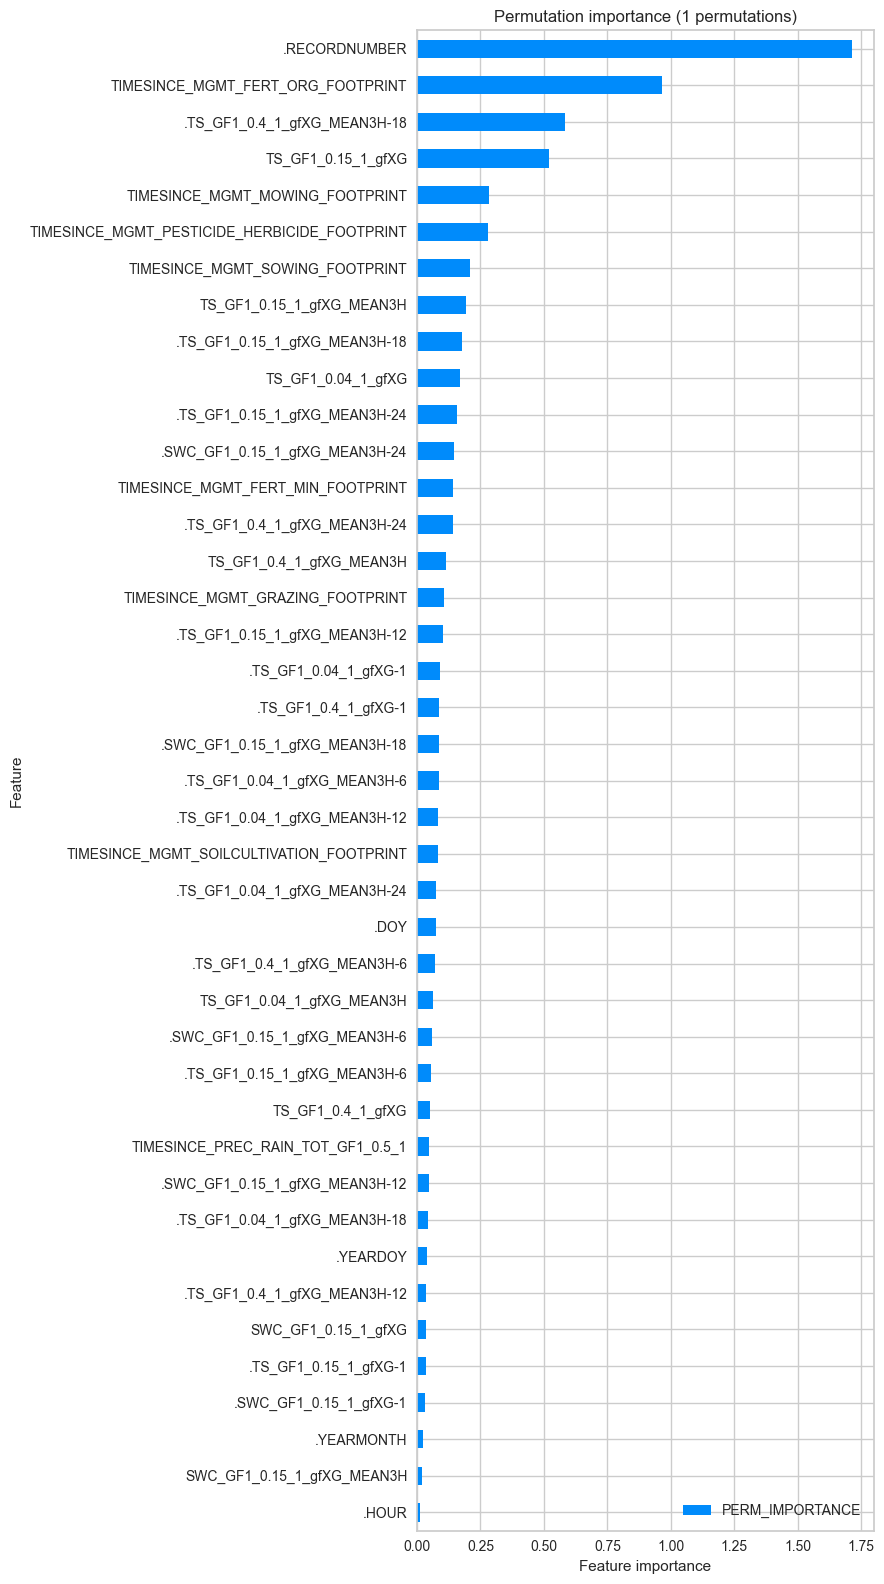

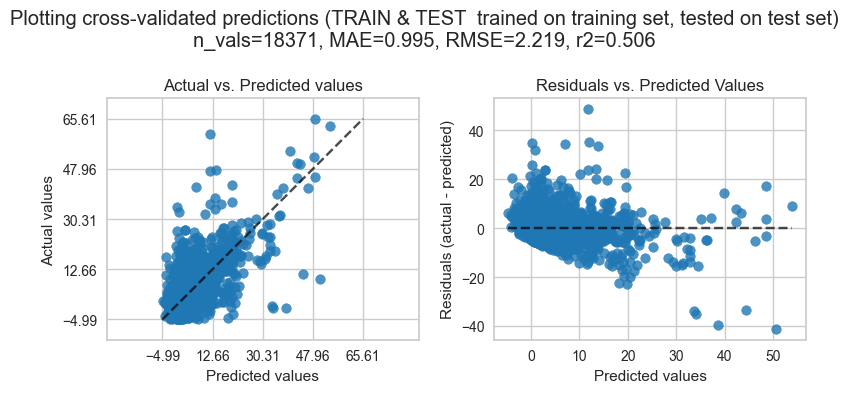

>>> Plotting residuals and prediction error ...


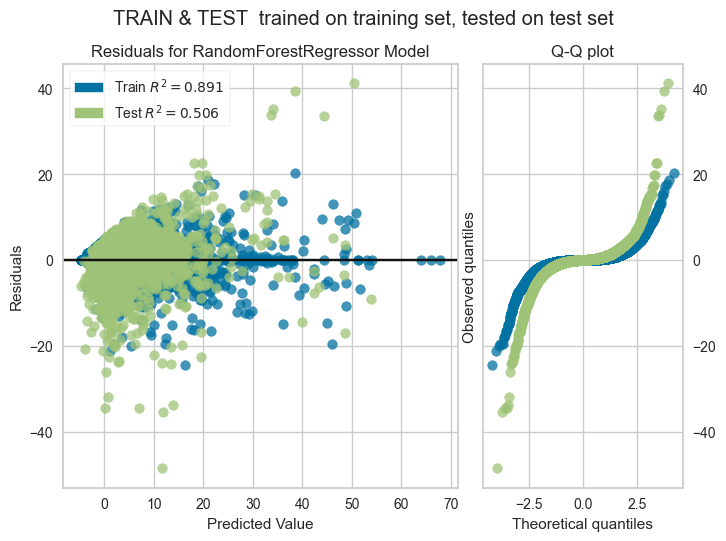

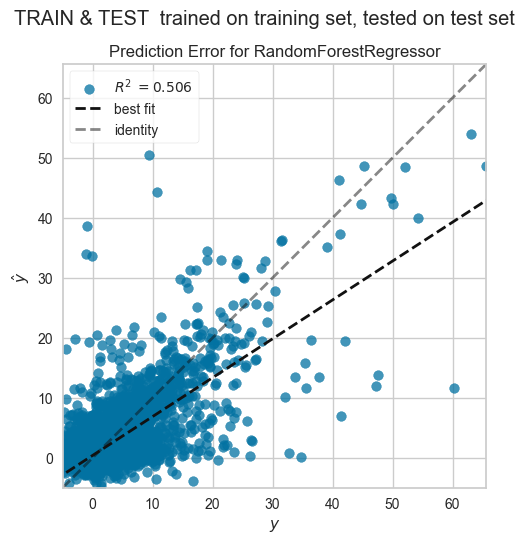

>>> Collecting results, details about training and testing can be accessed by calling .report_traintest().
>>> Done.


In [13]:
rfts.trainmodel(showplot_scores=True, showplot_importance=True)

In [14]:
# rfts.report_traintest()

</br>

## Apply model to fill gaps


Gap-filling using final model ...
>>> Using final model on all data to predict target FN2O_L3.1_L3.3_CUT_50_QCF ...
>>> Using final model on all data to calculate permutation importance ...
>>> Plotting feature importances (permutation importance) ...
>>> Calculating prediction scores based on all data predicting FN2O_L3.1_L3.3_CUT_50_QCF ...
>>> Plotting observed and predicted values based on all data ...


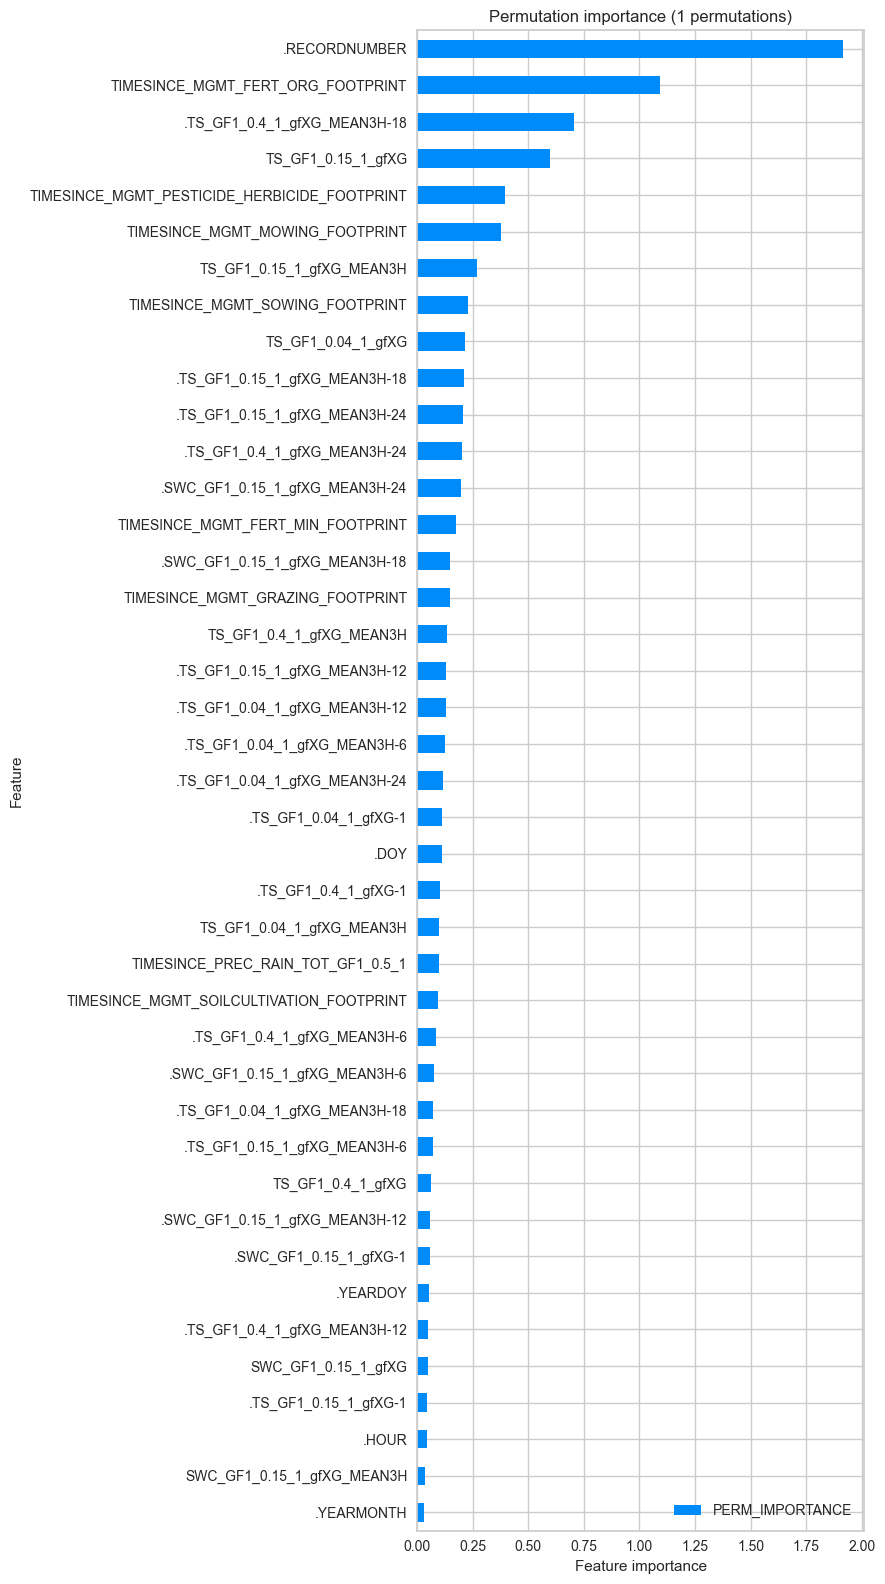

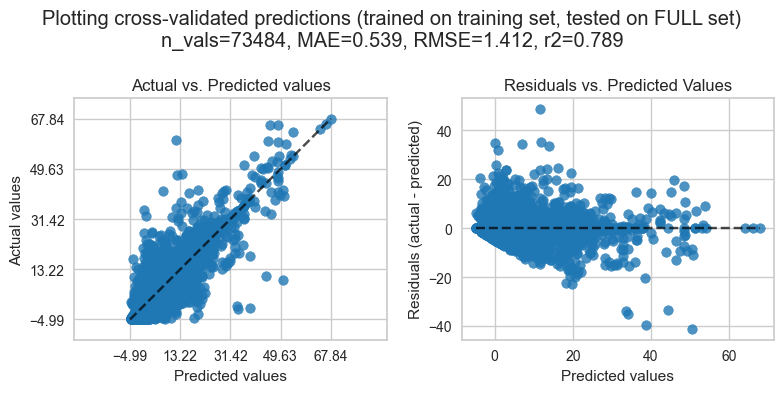

>>> Predicting target FN2O_L3.1_L3.3_CUT_50_QCF where all features are available ... predicted 192864 records.
>>> Collecting results for final model ...
>>> Filling 119380 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable FN2O_L3.1_L3.3_CUT_50_QCF_gfRF ...
>>> Restoring original timestamp in results ...

Gap-filling 0 remaining missing records in FN2O_L3.1_L3.3_CUT_50_QCF_gfRF using fallback model ...
>>> Fallback model not necessary, all gaps were already filled.
>>> Combining predictions from full model and fallback model ...


In [15]:
rfts.fillgaps(showplot_scores=True, showplot_importance=True)

In [16]:
rfts.report_gapfilling()


GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (119380 values, FN2O_L3.1_L3.3_CUT_50_QCF_gfRF where flag=1) in comparison to observed targets (73484 values, FN2O_L3.1_L3.3_CUT_50_QCF).

## TARGET
- first timestamp:  2012-01-01 00:15:00
- last timestamp:  2022-12-31 23:45:00
- potential number of values: 192864 values)
- target column (observed):  FN2O_L3.1_L3.3_CUT_50_QCF
- missing records (observed):  119380 (cross-check from flag: 119380)
- target column (gap-filled):  FN2O_L3.1_L3.3_CUT_50_QCF_gfRF  (192864 values)
- missing records (gap-filled):  0
- gap-filling flag: FLAG_FN2O_L3.1_L3.3_CUT_50_QCF_gfRF_ISFILLED
  > flag 0 ... observed targets (73484 values)
  > flag 1 ... targets gap-filled with high-quality, all features available (119380 values)
  > flag 2 ... targets gap-filled with fallback (0 values)

## FEATURE IMPORTANCES
- names of features used in model:  ['.RECORDNUMBER', 'TIMESINCE_MGMT_FERT_ORG_FOOTPRINT',

</br>

## Attributes
A lot more information about feature reduction, training and testing, model building and gap-filling is available via the class attributes.

In [17]:
# rfts.feature_importances_

In [18]:
# rfts.feature_importances_reduction_

In [19]:
# rfts.feature_importances_traintest_

In [20]:
# rfts.gapfilling_df_

In [21]:
# rfts.model_

In [22]:
# rfts.accepted_features_

In [23]:
# rfts.rejected_features_

In [24]:
# rfts.scores_

In [25]:
# rfts.scores_traintest_

In [26]:
# rfts.traintest_details_.keys()

</br>

## Result

In [27]:
var_new_gapfilled = rfts.get_gapfilled_target().name
var_new_flag = rfts.get_flag().name
new_gapfilling_df = rfts.gapfilling_df_
# new_gapfilling_df = new_gapfilling_df[[var_new_gapfilled, var_new_flag]]
new_gapfilling_df

,.PREDICTIONS_FULLMODEL,FN2O_L3.1_L3.3_CUT_50_QCF,.GAP_PREDICTIONS,FLAG_FN2O_L3.1_L3.3_CUT_50_QCF_gfRF_ISFILLED,FN2O_L3.1_L3.3_CUT_50_QCF_gfRF,.PREDICTIONS_FALLBACK,.GAPFILLED_CUMULATIVE,.PREDICTIONS
TIMESTAMP_MIDDLE,,,,,,,,
2012-01-01 00:15:00,1.238257,NaN,1.238257,1,1.238257,None,1.238257,1.238257
2012-01-01 00:45:00,1.238257,NaN,1.238257,1,1.238257,None,2.476513,1.238257
2012-01-01 01:15:00,1.238257,NaN,1.238257,1,1.238257,None,3.714770,1.238257
2012-01-01 01:45:00,1.238257,NaN,1.238257,1,1.238257,None,4.953027,1.238257
2012-01-01 02:15:00,1.238257,NaN,1.238257,1,1.238257,None,6.191283,1.238257
...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,-0.630203,NaN,-0.630203,1,-0.630203,None,250969.916591,-0.630203
2022-12-31 22:15:00,-0.630203,NaN,-0.630203,1,-0.630203,None,250969.286388,-0.630203
2022-12-31 22:45:00,-0.630203,NaN,-0.630203,1,-0.630203,None,250968.656184,-0.630203


</br>

## Plot

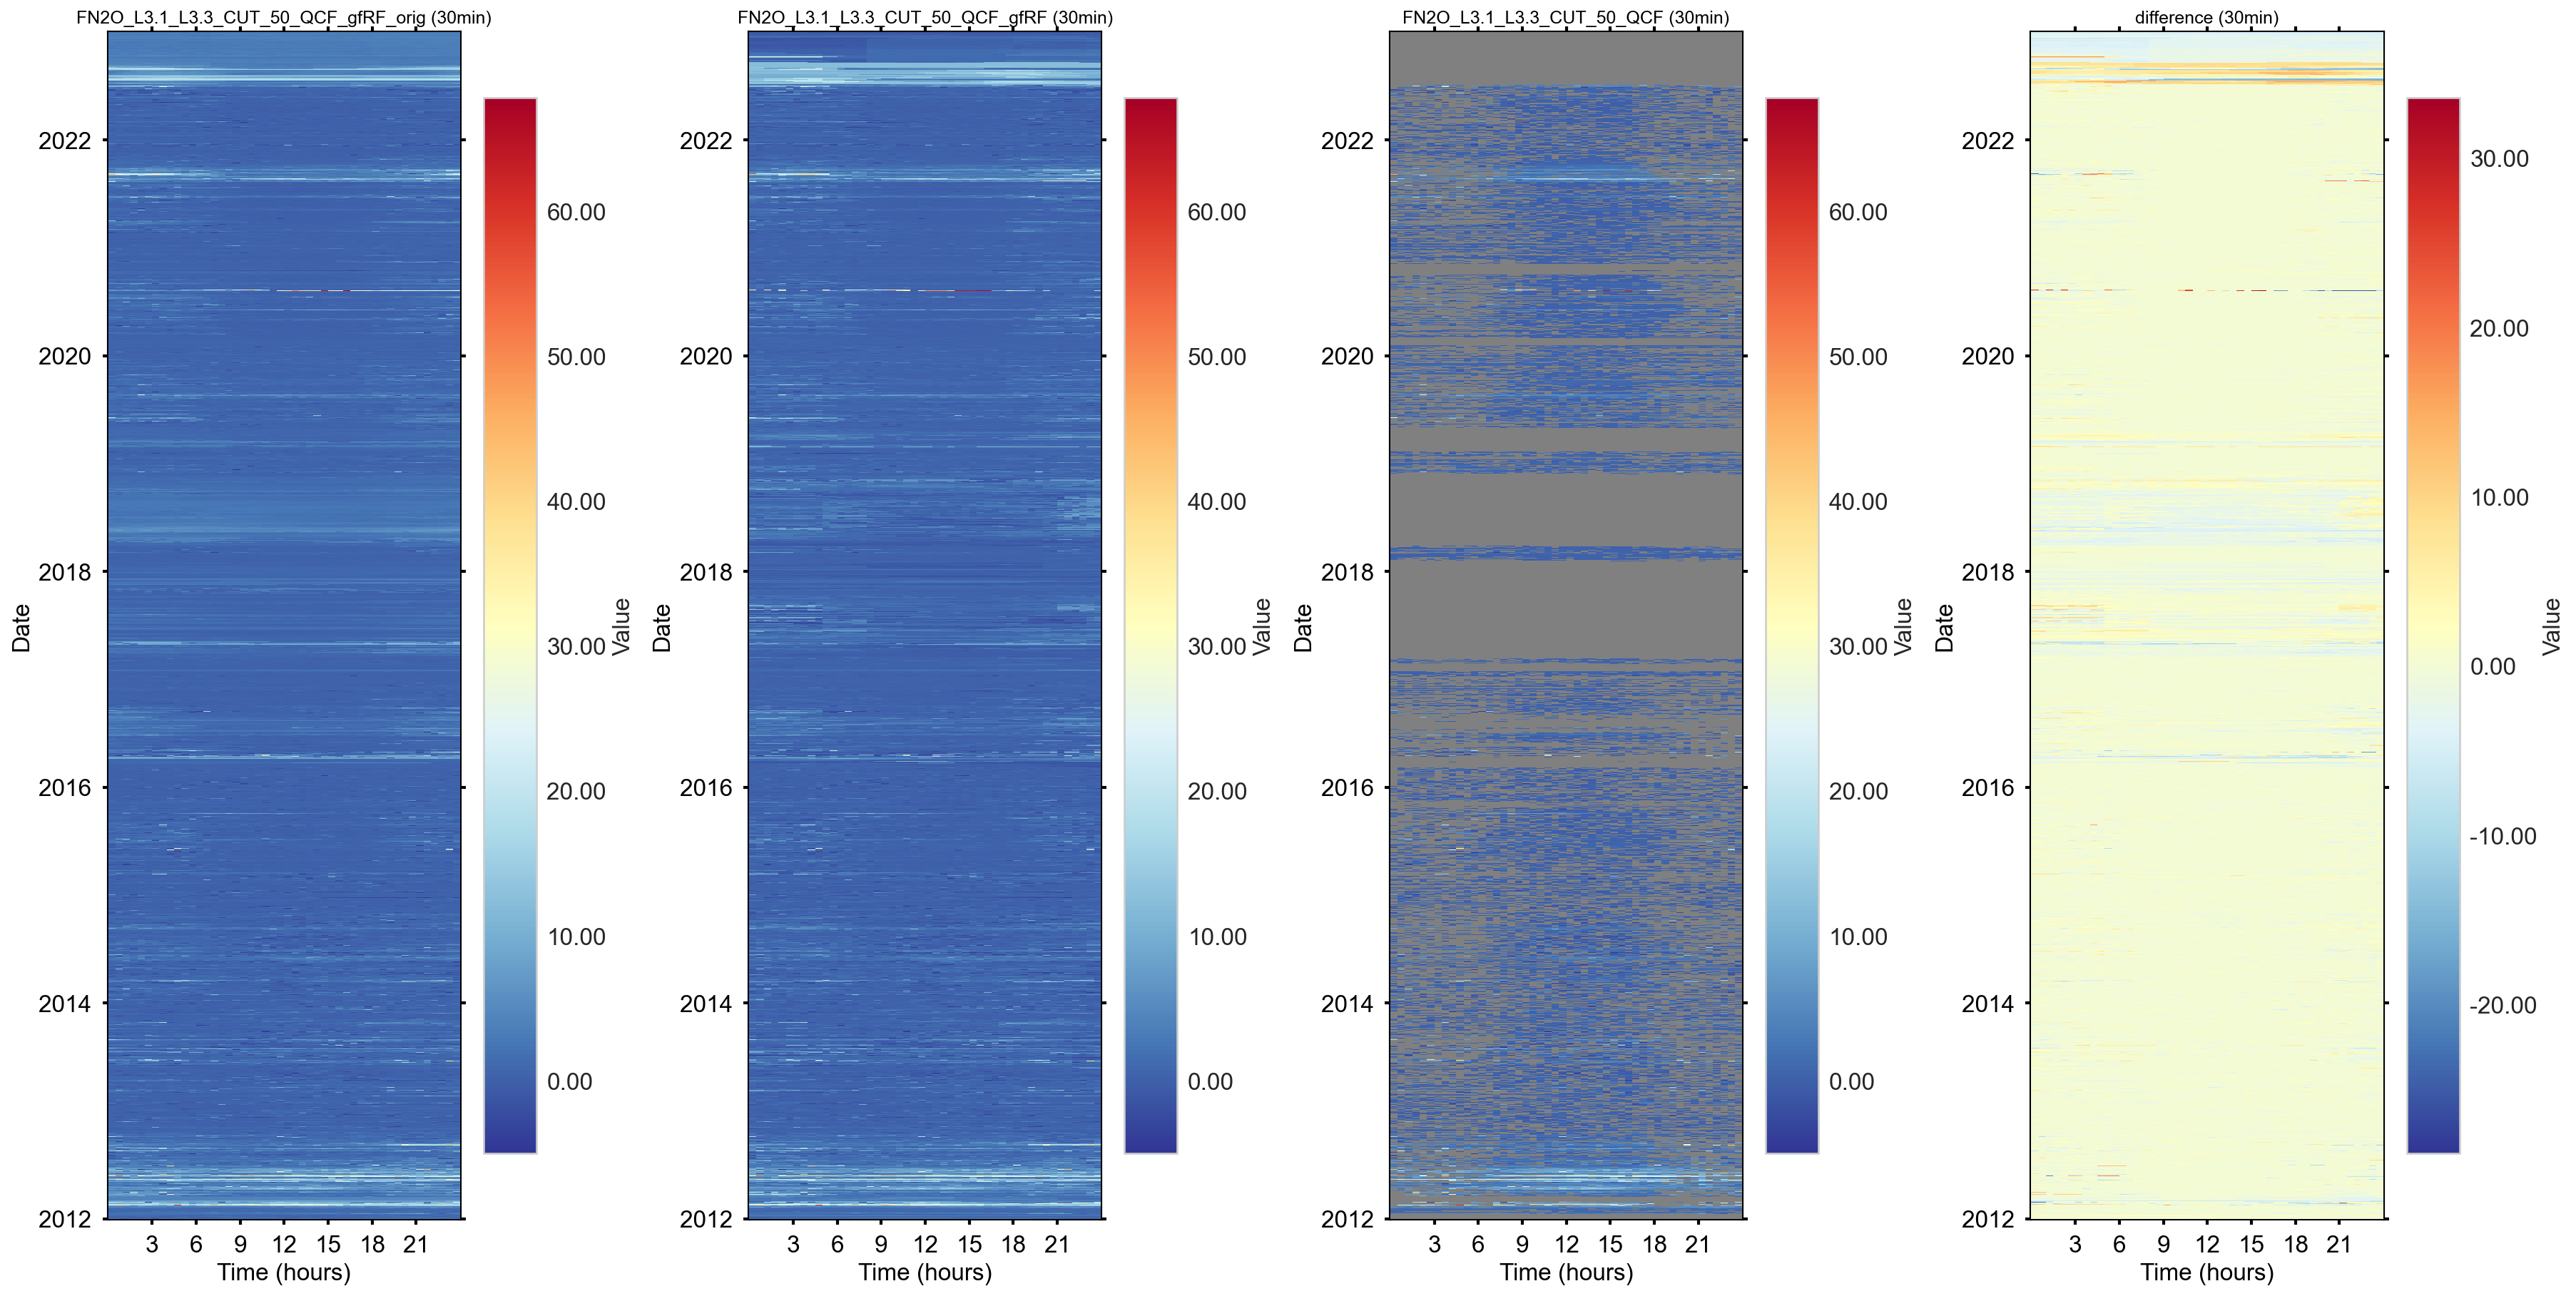

In [28]:
# Store previously gap-filled flux For comparison
flux_gapfilled_orig = FLUX_df[GAPF_var].copy()  
flux_gapfilled_orig.name = f"{GAPF_var}_orig"

diff = new_gapfilling_df[var_new_gapfilled].sub(flux_gapfilled_orig)
diff.name = "difference"

fig, axs = plt.subplots(ncols=4, figsize=(24, 12), dpi=150, layout="constrained")
HeatmapDateTime(series=flux_gapfilled_orig, ax=axs[0]).plot()  # Gap-filled flux from previous gap-filling
HeatmapDateTime(series=new_gapfilling_df[GAPF_var], ax=axs[1]).plot()  # New gap-filling
HeatmapDateTime(series=new_gapfilling_df[MEASURED_var], ax=axs[2]).plot()  # Original measured data
HeatmapDateTime(series=diff, ax=axs[3]).plot()  # Difference between previous gap-filling and new gap-filling, to check if it worked for the three years

In [29]:
# TimeSeries(series=new_gapfilling_df[var_new_gapfilled].cumsum()).plot()

# **Add three years back to main data**

## Identify locations that are replaced in previous gap-filling

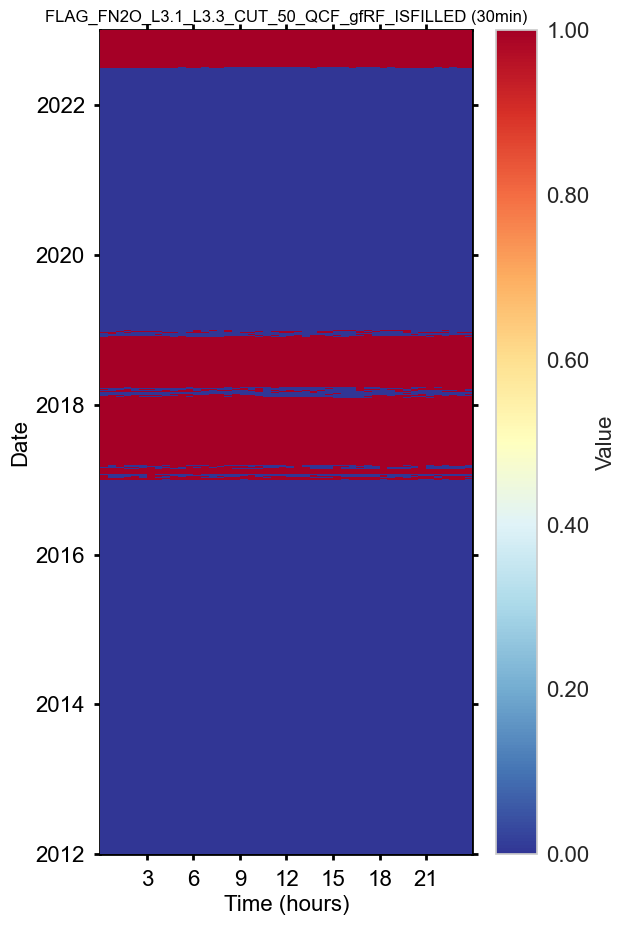

In [32]:
# Last day of flux measurement was 6 Jul 2022
replacelocs = ( (FLUX_df[FLAG_var] > 0) & (FLUX_df.index.year >= 2017) & (FLUX_df.index.year <= 2018) ) | ( (FLUX_df[FLAG_var] > 0) & (FLUX_df.index.date >= dt.date(2022, 7, 1)) )
HeatmapDateTime(series=replacelocs).plot()  # Previous gap-filling in the three years

## Remove records from previous gap-filling

In [33]:
FLUX_df.loc[replacelocs, GAPF_var] = np.nan
FLUX_df.loc[replacelocs, FLAG_var] = np.nan

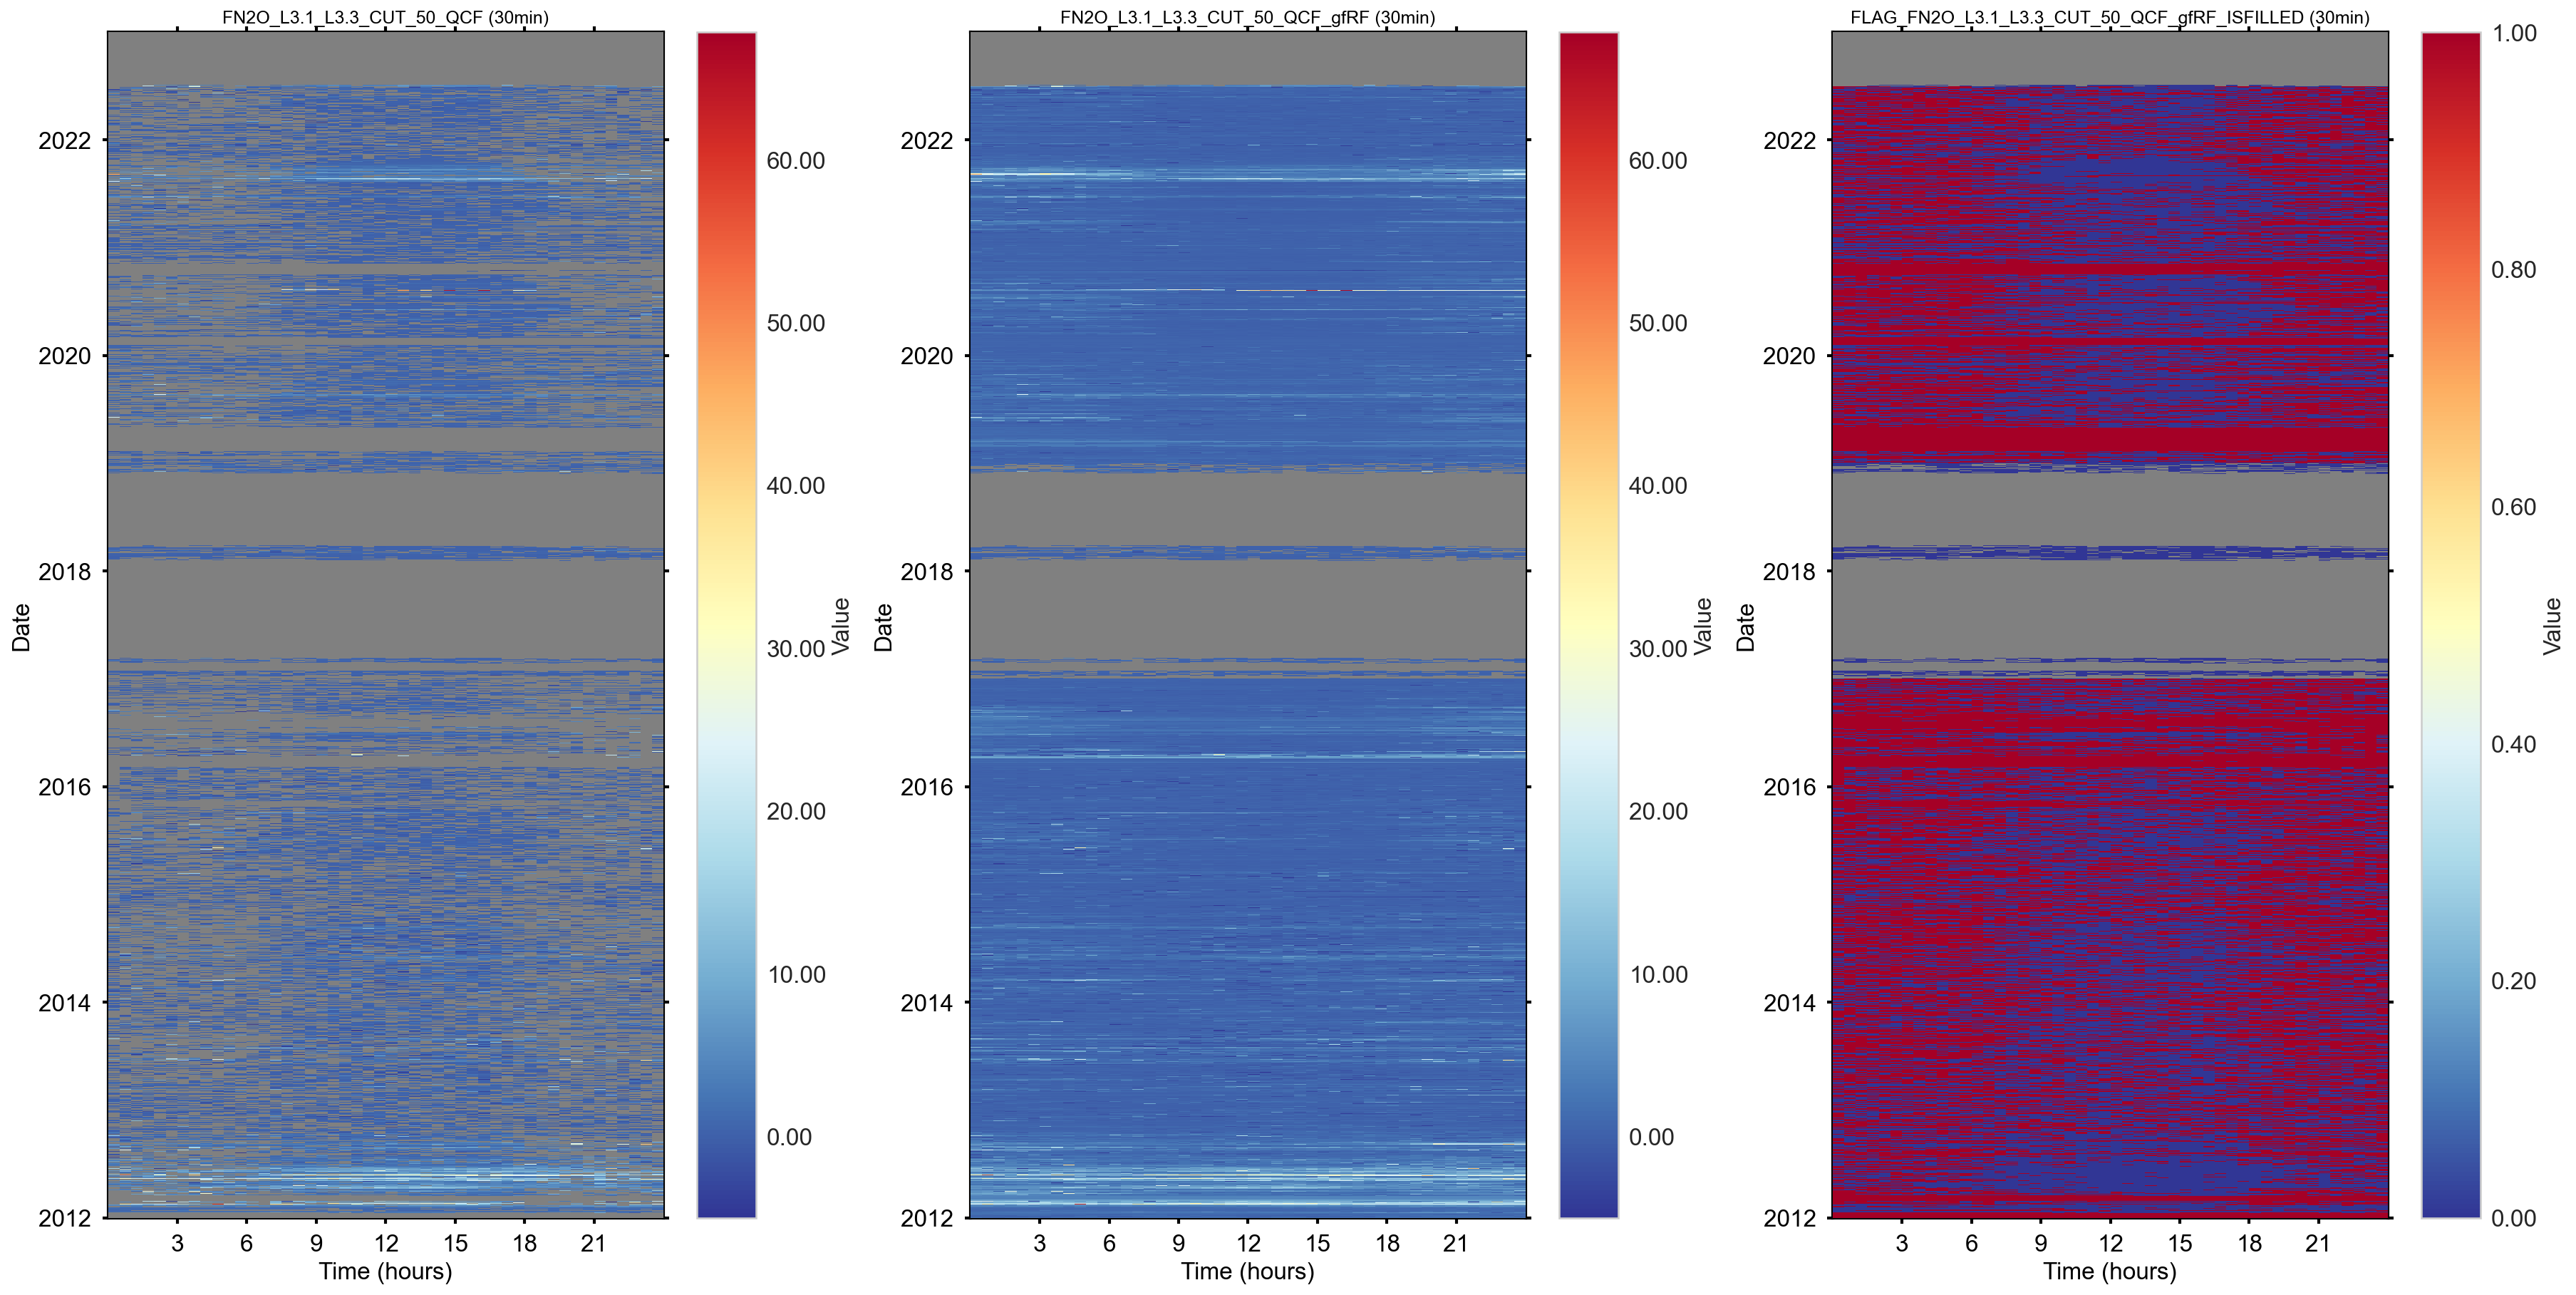

In [34]:
fig, axs = plt.subplots(ncols=3, figsize=(24, 12), dpi=150, layout="constrained")
HeatmapDateTime(series=FLUX_df[MEASURED_var], ax=axs[0]).plot()  # Previous gap-filling in the three years
HeatmapDateTime(series=FLUX_df[GAPF_var], ax=axs[1]).plot()  # New gap-filling in the three years
HeatmapDateTime(series=FLUX_df[FLAG_var], ax=axs[2]).plot()  #  Different scaling! Shows where OLD was replaced with NEW

In [ ]:
SUBSET_df = SUBSET_df.drop(FLAG_COL, axis=1)  # Remove flag column from subset, not needed as feature
SUBSET_df

In [ ]:
# Store for comparison
old = FLUX_df.loc[replacelocs, TARGET_COL].copy()
old.name = "OLD"
new = new_gapfilling_df.loc[replacelocs, var_new_gapfilled].copy()
new.name = "NEW"

# Replace three years with new gap-filling
FLUX_df.loc[replacelocs, TARGET_COL] = new_gapfilling_df.loc[replacelocs, var_new_gapfilled]
FLUX_df.loc[replacelocs, FLAG_COL] = new_gapfilling_df.loc[replacelocs, var_new_flag]

In [ ]:
# s = new_gapfilling_df.loc[replacelocs, var_new_gapfilled].copy()
# s.name = "check"
# HeatmapDateTime(series=s).plot()  # Gap-filled flux from previous gap-filling

fig, axs = plt.subplots(ncols=3, figsize=(24, 12), dpi=150, layout="constrained")
HeatmapDateTime(series=old, ax=axs[0]).plot()  # Previous gap-filling in the three years
HeatmapDateTime(series=new, ax=axs[1]).plot()  # New gap-filling in the three years
HeatmapDateTime(series=replacelocs, ax=axs[2]).plot()  #  Different scaling! Shows where OLD was replaced with NEW

In [ ]:
new_gapfilling_df[var_new_gapfilled].groupby(SUBSET_df.index.year).sum()

In [ ]:
flux_gapfilled_orig.groupby(flux_gapfilled_orig.index.year).sum()

# **Save to file**

In [ ]:
# # TODO!
# suffix = "N2O"
# outfile = f"51.3_FluxProcessingChain_L4.1_{suffix}"
# fpc.fpc_df.to_csv(f"{outfile}.csv")  # large file, slow to read
# save_parquet(data=fpc.fpc_df, filename=f"{outfile}")  # Smaller file, very fast to read

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [ ]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")